# Importing and Preprocessing

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

import datetime

import math
from sklearn.preprocessing import MinMaxScaler

from tqdm import tqdm
plt.style.use("fivethirtyeight")
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Bidirectional, GRU

In [ ]:
path = '/content/drive/MyDrive/air-quality-india.csv'
df=pd.read_csv(path)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36192 entries, 0 to 36191
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Timestamp  36192 non-null  object 
 1   Year       36192 non-null  int64  
 2   Month      36192 non-null  int64  
 3   Day        36192 non-null  int64  
 4   Hour       36192 non-null  int64  
 5   PM2.5      36192 non-null  float64
dtypes: float64(1), int64(4), object(1)
memory usage: 1.7+ MB


In [ ]:
df["Timestamp"] = pd.to_datetime(df["Timestamp"])

In [ ]:
df.head()

,Timestamp,Year,Month,Day,Hour,PM2.5
0,2017-11-07 12:00:00,2017,11,7,12,64.51
1,2017-11-07 13:00:00,2017,11,7,13,69.95
2,2017-11-07 14:00:00,2017,11,7,14,92.79
3,2017-11-07 15:00:00,2017,11,7,15,109.66
4,2017-11-07 16:00:00,2017,11,7,16,116.50


In [ ]:
df['Date']=df["Timestamp"].dt.date

# Visualization

* Time series by days

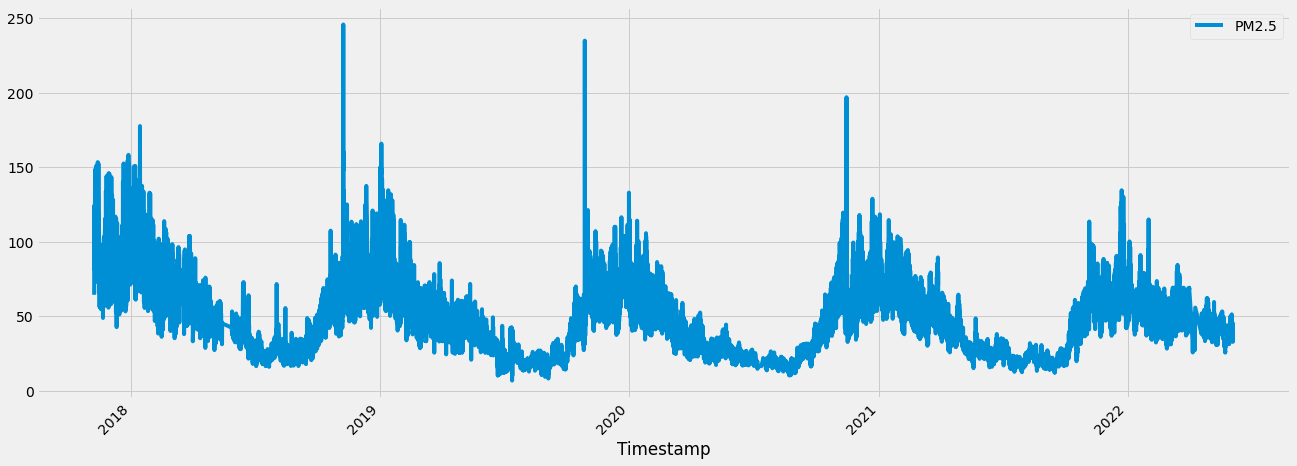

In [ ]:
df.plot(x='Timestamp',y='PM2.5',figsize=(20,8))
plt.xticks(rotation=45)

plt.show()

* Time series by year average

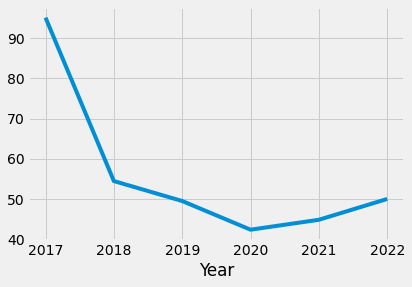

In [ ]:
df.groupby('Year')['PM2.5'].mean().plot()

* Boxplot by year

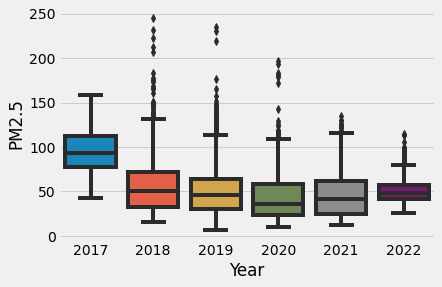

In [ ]:
df_year=df.loc[:,['Year','PM2.5']]
sns.boxplot(x='Year', y='PM2.5',data=df_year)

* Time series by month average

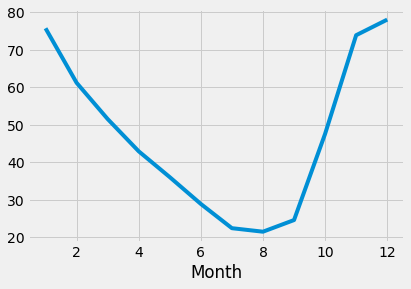

In [ ]:
df.groupby('Month')['PM2.5'].mean().plot()

* Boxplot by month

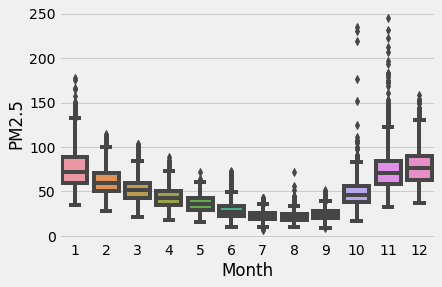

In [ ]:
df_month=df.loc[:,['Month','PM2.5']]
sns.boxplot(x='Month', y='PM2.5',data=df_month)

* Time series by day average

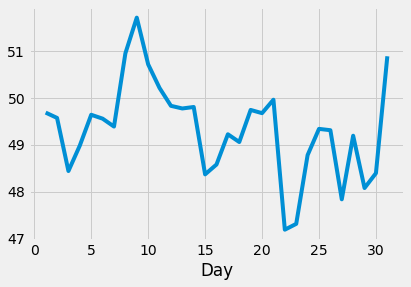

In [ ]:
df.groupby('Day')['PM2.5'].mean().plot()

* Boxplot by day

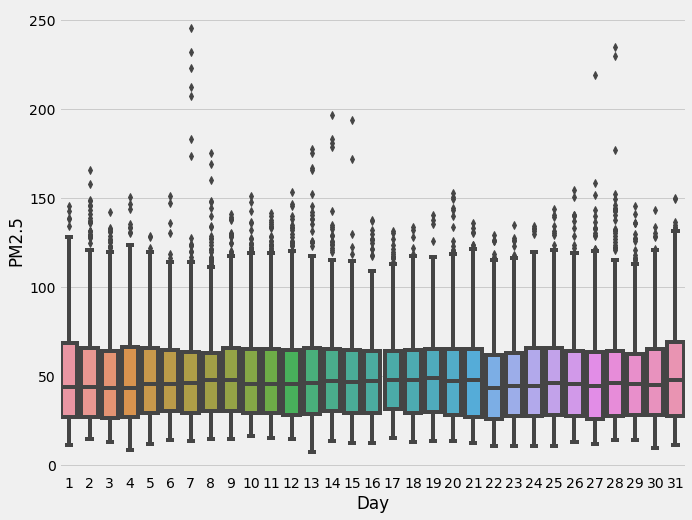

In [ ]:
df_day=df.loc[:,['Day','PM2.5']]
plt.figure(figsize=(10,8))
sns.boxplot(x='Day', y='PM2.5',data=df_day)

* Time series by hour average

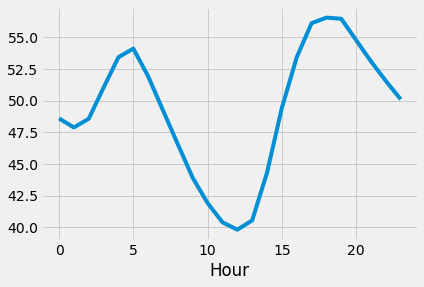

In [ ]:
df.groupby('Hour')['PM2.5'].mean().plot()

* Boxplot by hour

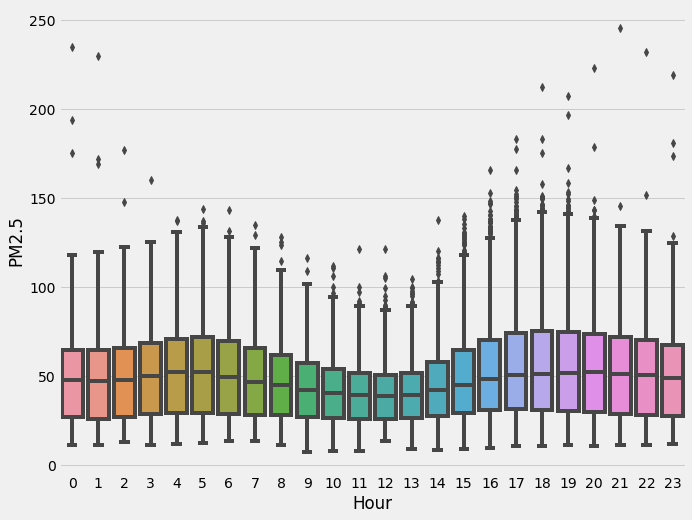

In [ ]:
df_hour=df.loc[:,['Hour','PM2.5']]
plt.figure(figsize=(10,8))
sns.boxplot(x='Hour', y='PM2.5',data=df_hour)

# Prediction Model

* I tried to find the prediction model by each days average. So first, I made each days average data set.

In [ ]:
df_date=pd.DataFrame(df.groupby('Date')['PM2.5'].mean())
df_date

,PM2.5
Date,
2017-11-07,99.805833
2017-11-08,110.979565
2017-11-09,114.915833
2017-11-10,119.404091
2017-11-11,109.267273
...,...
2022-05-31,41.465417
2022-06-01,41.645833
2022-06-02,42.255417


* Time series by each days average

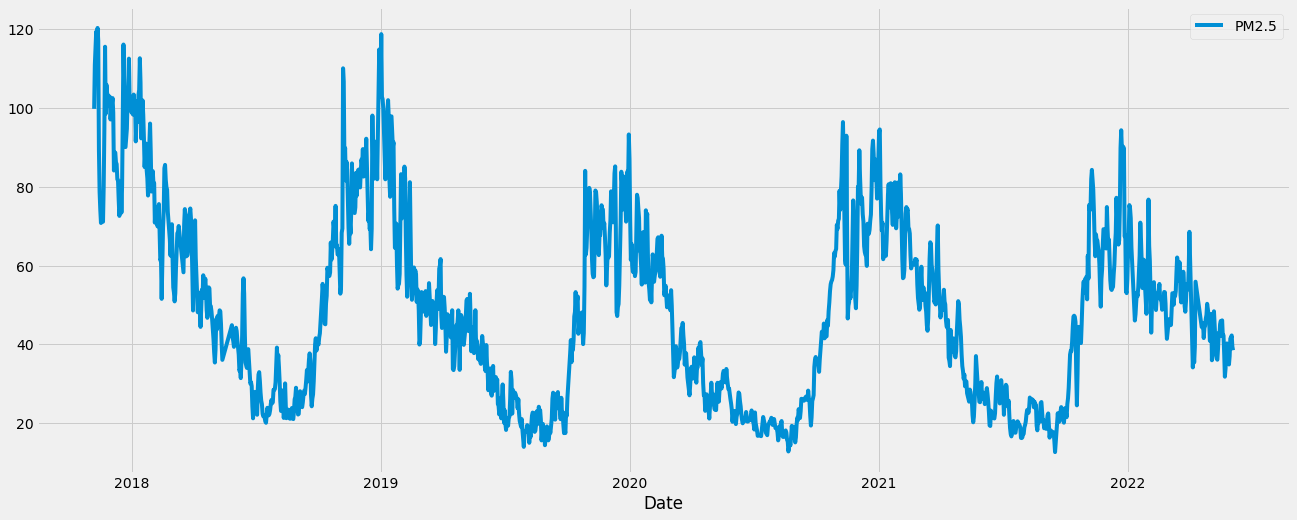

In [ ]:
df_date.plot(figsize=(20,8))

* Split data into train 80% and test 20%

In [ ]:
dataset  = df_date.values
training_data_len = math.ceil(len(dataset)*.8)
training_data_len

1293

In [ ]:
data = dataset
sar = sm.tsa.statespace.SARIMAX(data.sales_diff, order=(12, 0,
                                    0), seasonal_order=(0, 1, 0,
                                    12), trend='c').fit()

# Generate predictions
start, end, dynamic = 40, 100, 7
data['pred_value'] = sar.predict(start=start, end=end,
                                  dynamic=dynamic)
# Call helper functions to undo scaling & create prediction df
original_df = load_data('../data/monthly_data.csv')
unscaled_df = predict_df(data, original_df)
# Call helper functions to print scores and plot results
get_scores(unscaled_df, original_df, 'ARIMA')
plot_results(unscaled_df, original_df, 'ARIMA')

In [ ]:
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.feature_selection import RFECV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error

In [ ]:
#Model Selection based on validation error
kfold=KFold(n_splits=10, shuffle=True, random_state=0)
model_factory = [DecisionTreeRegressor(), RandomForestRegressor(), KNeighborsRegressor(), SVR(), XGBRegressor()]
for model in model_factory:
    scores = cross_val_score(model, features, target, cv=kfold, scoring='neg_mean_absolute_error')
    print(model.__class__.__name__, ": Cross Validation Error:", -np.mean(scores))

NameError: ignored

In [ ]:
rfe = RFECV(XGBRegressor(), step=2, min_features_to_select=2, cv=kfold, scoring='r2')
rfe = rfe.fit(features, target)
print("Optimum no. of features", rfe.n_features_)
print("Selected features", features.columns[rfe.support_])
plt.figure(figsize=(10, 9))
plt.xlabel('# of featuers')
plt.ylabel('Accuracy')
plt.plot(range(1, len(rfe.grid_scores_)+1) , rfe.grid_scores_.mean(axis=1))
plt.figure()

* Standardization by MinMaxScaler

In [ ]:
sc = MinMaxScaler(feature_range=(0,1))
scaled_data = sc.fit_transform(dataset)
scaled_data

array([[0.80924161],
       [0.91297267],
       [0.94951492],
       ...,
       [0.27497376],
       [0.24870153],
       [0.24014526]])

In [ ]:
train_data = scaled_data[0:training_data_len, :]
x_train = []
y_train = []
num = 60
for i in range(num, len(train_data)):
    x_train.append(train_data[i-num:i , 0])
    y_train.append(train_data[i , 0])

In [ ]:
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))
x_train.shape

(1233, 60, 1)

Holt Winters

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.seasonal import seasonal_decompose
# holt winters
# single exponential smoothing
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
# double and triple exponential smoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [ ]:
from sklearn.model_selection import train_test_split
train_inputs, val_inputs, train_targets, val_targets = train_test_split(inputs,
                                                                        target,
                                                                        test_size=0.25,
                                                                        random_state=42)


In [ ]:
m = 1
alpha = 1/(2*m)
shwes_fitted = SimpleExpSmoothing(x_train[0]).fit(smoothing_level=alpha,optimized=False,use_brute=True).fitted_values
shwes = SimpleExpSmoothing(x_train[0]).fit(smoothing_level=alpha,optimized=False,use_brute=True)

In [ ]:
test_predictions = shwes.forecast(y_test.shape[0])

In [ ]:
from sklearn.metrics import mean_absolute_error,mean_squared_error
print(f'Mean Absolute Error = {mean_absolute_error(y_test,test_predictions)}')
print(f'Mean Squared Error = {mean_squared_error(y_test,test_predictions)}')

Mean Absolute Error = 43.40082428915019
Mean Squared Error = 2221.4897657362067


In [ ]:
[y_test, test_predictions]

* Modeling

In [ ]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

In [ ]:
model.compile(optimizer = "adam", loss = "mean_squared_error")

In [ ]:
model.fit(x_train,y_train, batch_size=1, epochs=1)

1233/1233 [==============================] - 45s 34ms/step - loss: 0.0072


* Prediction

In [ ]:
test_data = scaled_data[training_data_len-60: , :]
x_test = []
y_test = dataset[training_data_len:,:]
for i in range(num, len(test_data)):
      x_test.append(test_data[i-num:i, 0])

In [ ]:
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [ ]:
predictions = model.predict(x_test)
predictions = sc.inverse_transform(predictions)

In [ ]:
rmse = np.sqrt(np.mean(predictions - y_test)**2)
rmse

2.764560952721826

In [ ]:
import sklearn.metrics
sklearn.metrics.r2_score(y_test, predictions)

0.8486095824928311

In [ ]:
sklearn.__version__

'1.0.2'

In [ ]:
print(f'Mean Absolute Error = {mean_absolute_error(y_test,predictions)}')
print(f'Mean Squared Error = {mean_squared_error(y_test,predictions)}')

NameError: ignored

In [ ]:
train = df_date[:training_data_len]
valid = df_date[training_data_len:]
valid["Predictions"] = predictions
valid

,PM2.5,Predictions
Date,,
2021-06-28,28.667917,27.178453
2021-06-29,30.903750,27.202154
2021-06-30,29.017917,27.831181
2021-07-01,27.166667,28.147299
2021-07-02,27.132917,27.958038
...,...,...
2022-05-31,41.465417,35.603333
2022-06-01,41.645833,36.485973
2022-06-02,42.255417,37.463890


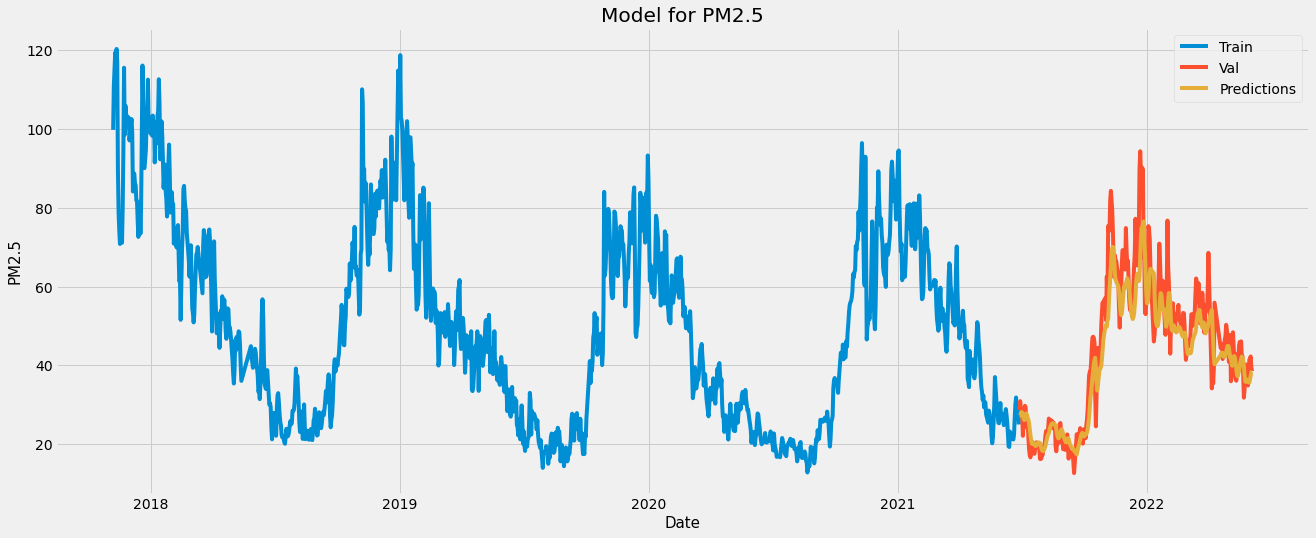

In [ ]:
plt.figure(figsize=(20,8))
plt.title("Model for PM2.5")
plt.xlabel("Date", fontsize = 15)
plt.ylabel("PM2.5",fontsize=15)
plt.plot(train[df_date.columns])
plt.plot(valid['PM2.5'])
plt.plot(valid["Predictions"])
plt.legend(["Train","Val","Predictions"])

Thank you !

**Bidirectional LSTM**

In [ ]:
# Create BiLSTM model
def create_model_bilstm(units):
    model = Sequential()
    model.add(Bidirectional(LSTM(units = units,
              return_sequences=True),
              input_shape=(x_train.shape[1], x_train.shape[2])))
    model.add(Bidirectional(LSTM(units = units)))
    model.add(Dense(1))
    #Compile model
    model.compile(loss='mse', optimizer='adam')
    return model
# Create LSTM or GRU model
def create_model(units, m):
    model = Sequential()
    model.add(m (units = units, return_sequences = True,
                input_shape = [x_train.shape[1], x_train.shape[2]]))
    model.add(Dropout(0.2))
    model.add(m (units = units))
    model.add(Dropout(0.2))
    model.add(Dense(units = 1))
    #Compile model
    model.compile(loss='mse', optimizer='adam')
    return model
# BiLSTM
model_bilstm = create_model_bilstm(64)
# GRU and LSTM
model_gru = create_model(64, GRU)
model_lstm = create_model(64, LSTM)


In [ ]:
from tensorflow import keras
def fit_model(model):
    early_stop = keras.callbacks.EarlyStopping(monitor = 'val_loss',
                                               patience = 10)
    history = model.fit(x_train, y_train, epochs = 100,
                        validation_split = 0.2, batch_size = 32,
                        shuffle = False, callbacks = [early_stop])
    return history

In [ ]:
history_lstm = fit_model(model_lstm)

Epoch 1/100
31/31 [==============================] - 9s 104ms/step - loss: 0.0403 - val_loss: 0.0153
Epoch 2/100
31/31 [==============================] - 2s 76ms/step - loss: 0.0101 - val_loss: 0.0103
Epoch 3/100
31/31 [==============================] - 2s 76ms/step - loss: 0.0080 - val_loss: 0.0079
Epoch 4/100
31/31 [==============================] - 2s 74ms/step - loss: 0.0082 - val_loss: 0.0098
Epoch 5/100
31/31 [==============================] - 2s 75ms/step - loss: 0.0074 - val_loss: 0.0081
Epoch 6/100
31/31 [==============================] - 2s 76ms/step - loss: 0.0082 - val_loss: 0.0132
Epoch 7/100
31/31 [==============================] - 2s 75ms/step - loss: 0.0071 - val_loss: 0.0072
Epoch 8/100
31/31 [==============================] - 2s 75ms/step - loss: 0.0068 - val_loss: 0.0072
Epoch 9/100
31/31 [==============================] - 2s 75ms/step - loss: 0.0062 - val_loss: 0.0069
Epoch 10/100
31/31 [==============================] - 2s 76ms/step - loss: 0.0066 - val_loss: 0.007

In [ ]:
history_bilstm = fit_model(model_bilstm)
history_gru = fit_model(model_gru)

Epoch 1/100
31/31 [==============================] - 15s 189ms/step - loss: 0.0542 - val_loss: 0.0326
Epoch 2/100
31/31 [==============================] - 4s 132ms/step - loss: 0.0154 - val_loss: 0.0143
Epoch 3/100
31/31 [==============================] - 4s 134ms/step - loss: 0.0088 - val_loss: 0.0094
Epoch 4/100
31/31 [==============================] - 4s 132ms/step - loss: 0.0064 - val_loss: 0.0079
Epoch 5/100
31/31 [==============================] - 4s 132ms/step - loss: 0.0053 - val_loss: 0.0064
Epoch 6/100
31/31 [==============================] - 4s 134ms/step - loss: 0.0049 - val_loss: 0.0077
Epoch 7/100
31/31 [==============================] - 4s 135ms/step - loss: 0.0074 - val_loss: 0.0086
Epoch 8/100
31/31 [==============================] - 4s 134ms/step - loss: 0.0063 - val_loss: 0.0102
Epoch 9/100
31/31 [==============================] - 4s 134ms/step - loss: 0.0065 - val_loss: 0.0061
Epoch 10/100
31/31 [==============================] - 4s 134ms/step - loss: 0.0045 - val_l

In [ ]:
def prediction(model):
    prediction = model.predict(x_test)
    prediction = sc.inverse_transform(prediction)
    return prediction
prediction_bilstm = prediction(model_bilstm)
prediction_gru = prediction(model_gru)

In [ ]:
prediction_lstm = prediction(model_lstm)

In [ ]:
def evaluate_prediction(predictions, actual, model_name):
    errors = predictions - actual
    mse = np.square(errors).mean()
    rmse = np.sqrt(mse)
    mae = np.abs(errors).mean()
    print(model_name + ':')
    print('Mean Absolute Error: {:.4f}'.format(mae))
    print('Root Mean Square Error: {:.4f}'.format(rmse))
    print('')
evaluate_prediction(prediction_bilstm, y_test, 'Bidirectional LSTM')
evaluate_prediction(prediction_gru, y_test, 'GRU')

Bidirectional LSTM:
Mean Absolute Error: 3.5954
Root Mean Square Error: 5.2144

GRU:
Mean Absolute Error: 3.2352
Root Mean Square Error: 4.9699



In [ ]:
evaluate_prediction(prediction_lstm, y_test, 'LSTM')

LSTM:
Mean Absolute Error: 4.3820
Root Mean Square Error: 6.0394



In [ ]:
import sklearn.metrics
print("Bidirectional")
print(sklearn.metrics.r2_score(y_test, prediction_bilstm))
print("GRU")
sklearn.metrics.r2_score(y_test, prediction_gru)

Bidirectional
0.9195233318350249
GRU


0.9268916187987415

In [ ]:
print("LSTM")
sklearn.metrics.r2_score(y_test, prediction_lstm)

LSTM


0.8920423050867599